nodes.shape=(4, 8, 8, 2)
depot_indices=array([[0, 0],
       [0, 7],
       [7, 0],
       [7, 7]])
target_indices=array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [2, 5],
       [2, 6],
       [2, 7],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4],
       [3, 5],
       [3, 6],
       [3, 7],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [4, 6],
       [4, 7],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [5, 4],
       [5, 5],
       [5, 6],
       [5, 7],
       [6, 0],
       [6, 1],
       [6, 2],
       [6, 3],
       [6, 4],
       [6, 5],
       [6, 6],
       [6, 7],
       [7, 1],
       [7, 2],
       [7, 3],
       [7, 4],
       [7, 5],


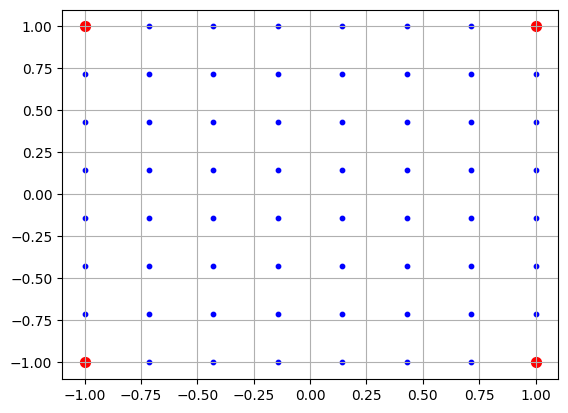

In [187]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = 4
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 8
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
nodes = nodes.reshape((1,) + nodes.shape)
nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
# depots_i = np.array([[0, 0]])
## Four depot nodes (one in each corner)
depot_indices = np.array([[0, 0], [0, n-1], [n-1, 0], [n-1,n-1]])
print(f"{depot_indices=}")
target_indices = []
for i in range(n):
    for j in range(n):
        is_depot = False
        for depot in depot_indices:
            if i == depot[0] and j == depot[1]:
                is_depot = True
                continue
        if not is_depot:
            target_indices.append([i,j])
target_indices = np.array(target_indices)
print(f"{target_indices=}")

# Chose starting depot node
B_k = depot_indices
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[0,:,:,0], nodes[0,:,:,1], c='blue', s=10)
plt.scatter(nodes[0,depot_indices[:,0],depot_indices[:,1],0], nodes[0,depot_indices[:,0],depot_indices[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [188]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = np.sqrt((nodes[0,i1,j1,0]-nodes[0,i2,j2,0]) ** 2 + (nodes[0,i1,j1,1]-nodes[0,i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
# cost = cost.reshape((1,) + cost.shape)
# cost = np.concatenate([cost for _ in range(k)], axis=0)
print(f"{cost.shape=}")


cost.shape=(8, 8, 8, 8)


In [189]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# Set the OBJECTIVE FUNCTION
# ((1+q_k) * c_{ij}) * x^{k}_{ij}
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    are_both_depot = False
    for d1 in depot_indices:
        if d1[0] != i1 or d1[1] != j1 : continue
        for d2 in depot_indices:
            if d2[0] != i2 or d2[1] != j2: continue
            are_both_depot = True
    if not are_both_depot:
        for ki in range(k):
            _ = m.addConstr(x[ki,i1,j1,i2,j2] <= 1)
# Above code handles A. Integer Constraints (4) and (5)

In [190]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i1,j1,:,:].sum() == 1 for i1, j1 in target_indices)
_ = m.addConstrs(x[:,:,:,i1,j1].sum() == 1 for i1, j1 in target_indices)

# (8) and (9) Begin and end at same position B_k
_ = m.addConstrs(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() <= 1 for ki in range(k))
_ = m.addConstrs(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() <= 1 for ki in range(k))
# (10) Every robot that visits a target leaves the target
_ = m.addConstrs((x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:]).sum() == 0 for ki in range(k) for i1 in range(n) for j1 in range(n))

# Additional constraints: no loopholes!
# _ = m.addConstrs(x[ki, i, j, i, j] == 0 for ki in range(k) for i in range(n) for j in range(n))
# Additional Constraints: symmetry!
# _ = m.addConstrs(x[ki, i1, j1, i2, j2] == x[ki, i2, j2, i1, j1] for ki in range(k) for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))

In [191]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,n,n,n,n), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

# (11) and (12) flow constraints
for ki in range(k):
    right_side = 0
    for i1, j1 in target_indices:
        for i2, j2 in itertools.product(range(n), range(n)):
            right_side += x[ki,i1,j1,i2,j2]
    _ = m.addConstr((p[ki,B_k[ki,0],B_k[ki,1],:,:] - p[ki,:,:,B_k[ki,0],B_k[ki,1]]).sum() == right_side)
_ = m.addConstrs((p[ki,:,:,i1,j1] - p[ki,i1,j1,:,:]).sum() == x[ki,i1,j1,:,:].sum() for ki in range(k) for i1, j1 in target_indices)

# # (13) Make sure target capacity doesn't change when passing through a depot
for ki in range(k):
    for i, (i1, j1) in enumerate(depot_indices):
        if i == ki:
            continue
        left_side = 0
        for i2, j2 in itertools.product(range(n), range(n)):
            left_side += p[ki,i2,j2,i1,j1] - p[ki,i1,j1,i2,j2]
        _ = m.addConstr(left_side == 0)
#
# # (14) Ensure that target capacity for each robot doesn't exceed |T|
_ = m.addConstrs(p[ki,i1,j1,i2,j2] <= len(target_indices) * x[ki,i1,j1,i2,j2] for ki in range(k) for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))


In [192]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
# L = 100.  # Fuel capacity ((1+q_k) fuel unit = 1 unit of distance)
# M = L * np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
# r = m.addMVar((k,n,n), name='r', vtype=GRB.INTEGER, lb=0, ub=L)  # (20) TODO: only appy for T?
#
# # (15) and (16)
# _ = m.addConstrs(r[ki,i2,j2] - r[ki,i1,j1] + cost[ki,i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in target_indices for i2, j2 in target_indices)
# _ = m.addConstrs(r[ki,i2,j2] - r[ki,i1,j1] + cost[ki,i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in target_indices for i2, j2 in target_indices)
#
# # (17) and (18)
# _ = m.addConstrs(r[ki,i2,j2] - L + cost[ki,i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in depot_indices for i2, j2 in target_indices)
# _ = m.addConstrs(r[ki,i2,j2] - L + cost[ki,i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in depot_indices for i2, j2 in target_indices)

In [193]:
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs(((1. + q_k) * cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

# m.setParam('TimeLimit', 100)
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-3770K CPU @ 3.50GHz, instruction set [SSE2|AVX]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to luffs.ottoman04@icloud.com
Optimize a model with 33348 rows, 32769 columns and 191684 nonzeros
Model fingerprint: 0xed9b40b6
Variable types: 1 continuous, 32768 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [6e+01, 6e+01]
  RHS range        [1e+00, 1e+00]
Presolve removed 16580 rows and 274 columns
Presolve time: 0.30s
Presolved: 16768 rows, 32495 columns, 173932 nonzeros
Variable types: 1 continuous, 32494 integer (16342 binary)
Found heuristic solution: objective 103.6514304
Found heuristic solution: objective 101.2059394
Found heuristic solution: objective 100.7344629
Found heuristic solution: objective 72.6272402
Determinist

Robot #0
-------
Staring position: [0 0] -> [-1.0, -1.0]


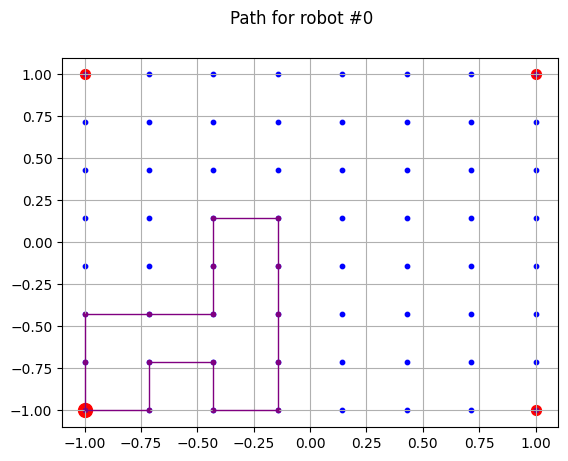

Robot #1
-------
Staring position: [0 7] -> [-1.0, 1.0]


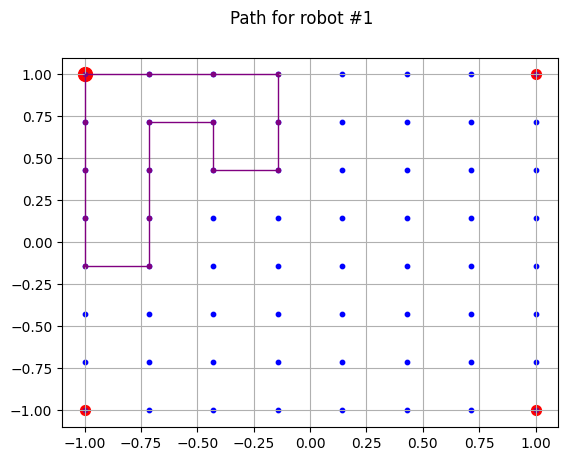

Robot #2
-------
Staring position: [7 0] -> [1.0, -1.0]


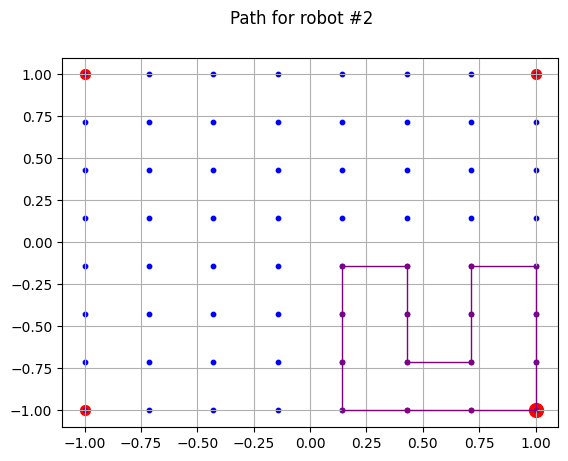

Robot #3
-------
Staring position: [7 7] -> [1.0, 1.0]


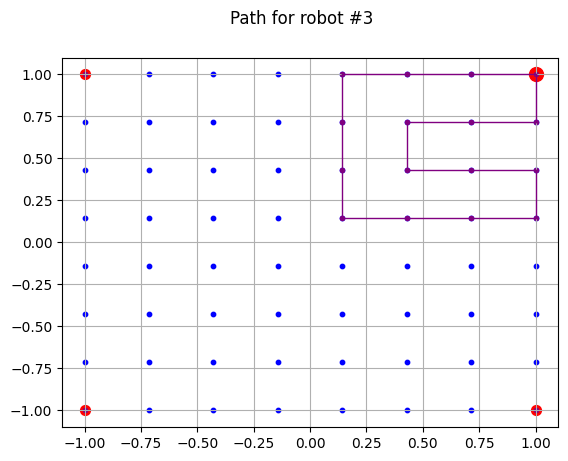

In [194]:
for ki in range(k):
    print(f"Robot #{ki}\n-------")
    print(f"Staring position: {B_k[ki]} -> {[nodes[0, B_k[ki, 0], B_k[ki, 1], 0], nodes[0, B_k[ki, 0], B_k[ki, 1], 1]]}")
    fig = plt.figure()
    fig.suptitle(f"Path for robot #{ki}")
    plt.scatter(nodes[0, :, :, 0], nodes[0, :, :, 1], c='blue', s=10)
    plt.scatter(nodes[0, depot_indices[:, 0], depot_indices[:, 1], 0], nodes[0, depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
    plt.scatter(nodes[0, B_k[ki, 0], B_k[ki, 1], 0], nodes[0, B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

    for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
        # if i1 == i2 and j1 == j2:
        #     continue
        if x.x[ki,i1, j1, i2, j2]:
            # if not(i1 == i2 and j1 == j2):
            # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
            plt.scatter(nodes[0, i1, j1, 0], nodes[0, i1, j1, 1], c="purple", s=8)
            plt.scatter(nodes[0, i2, j2, 0], nodes[0, i2, j2, 1], c="purple", s=8)
            plt.plot([nodes[0, i1, j1, 0], nodes[0, i2, j2, 0]], [nodes[0, i1, j1, 1], nodes[0, i2, j2, 1]], color="purple", linewidth=1)

    plt.grid()
    plt.show()



In [75]:
def get_neighbors(edges, node):
    neighbors = []
    for i1, j1 in itertools.product(range(n), range(n)):
        if edges[node[0],node[1],i1, j1]:
            neighbors.append((i1,j1))
    return neighbors

print(f"{B_k=}")
for ki in range(k):
    print(f"Robot #{ki}\n-------")

    current_node = (0,3)
    neighs = get_neighbors(x.x[ki], current_node)
    for neigh in neighs:
        print(f"Connection from {current_node} to {neigh}")


B_k=array([[0, 0],
       [0, 9],
       [9, 0],
       [9, 9]])
Robot #0
-------
Connection from (0, 3) to (1, 3)
Robot #1
-------
Robot #2
-------
Robot #3
-------
